In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

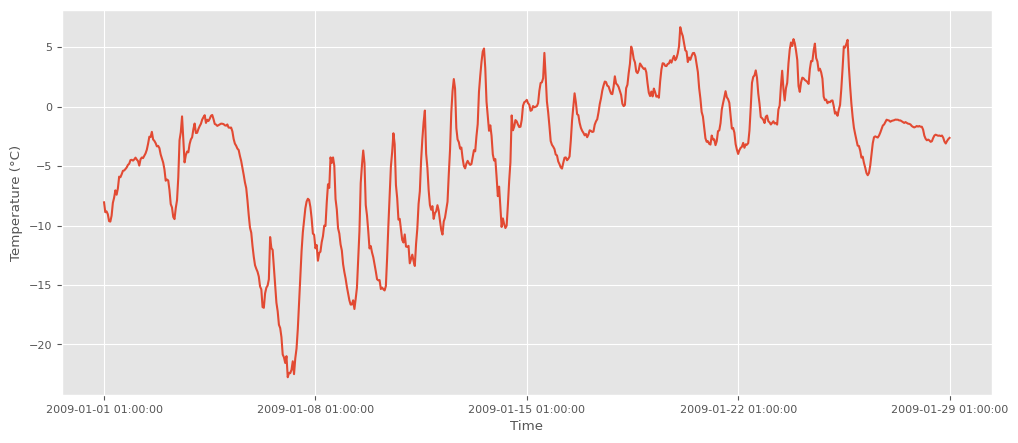

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

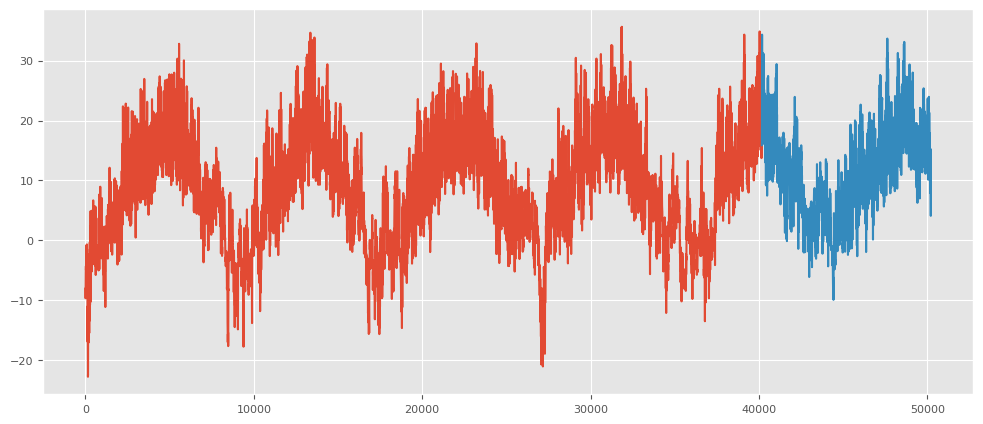

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

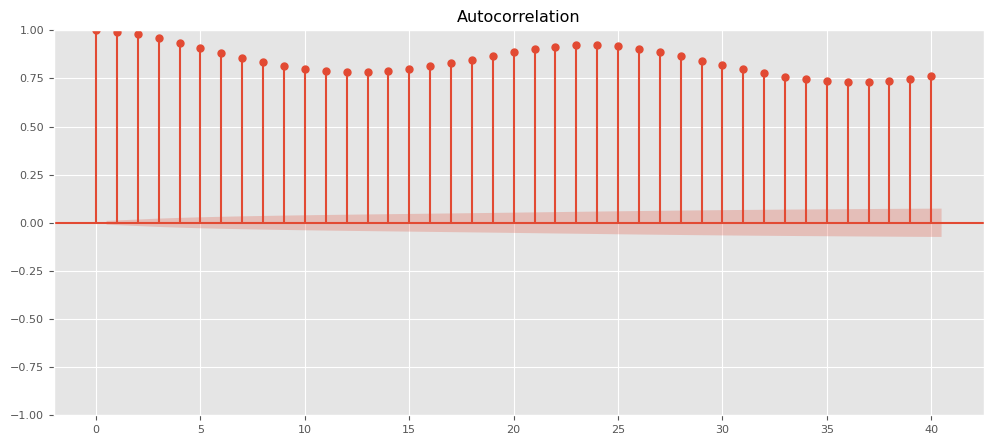

<Figure size 1200x500 with 0 Axes>

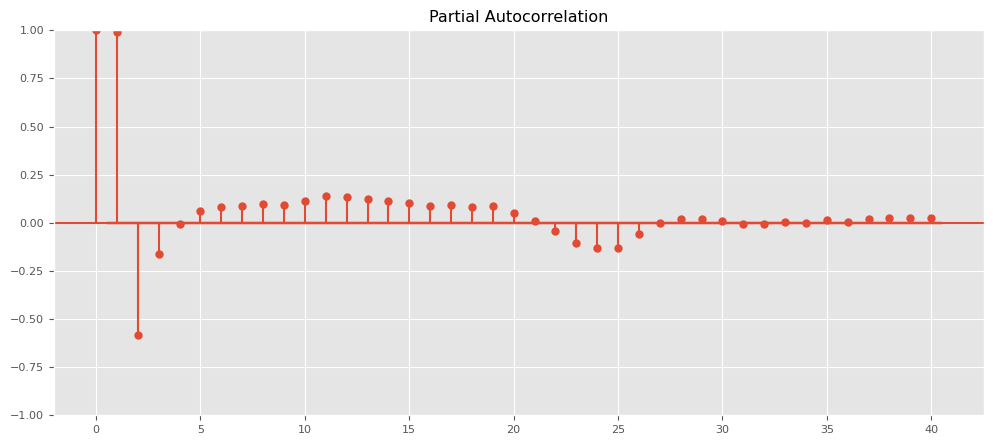

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EEMD

<Axes: xlabel='Time (samples)'>

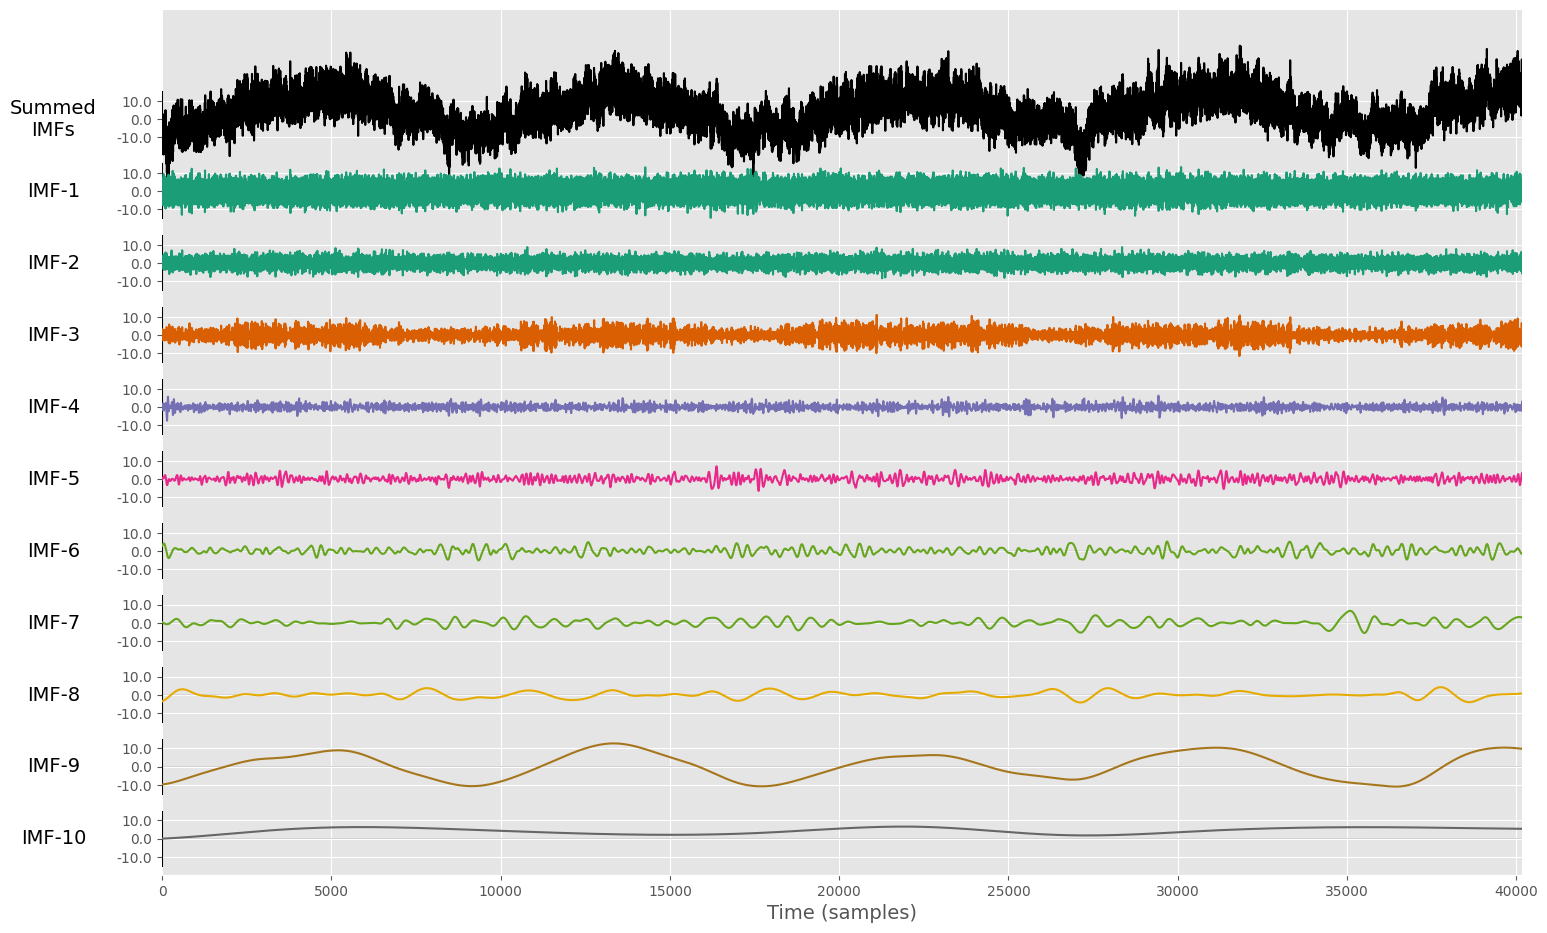

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,3.486835,2.260678,-1.816364,-1.574962,-0.331717,2.764852,0.406940,-3.638870,-9.832995,-0.049543
1,3.979385,0.744151,-0.839492,-1.654466,-0.288196,2.805687,0.391154,-3.631394,-9.830812,-0.048633
2,-4.828808,1.736629,0.344902,-1.710038,-0.240969,2.846494,0.375470,-3.623846,-9.828619,-0.047723
3,3.994478,3.456152,1.530104,-1.742414,-0.190443,2.887233,0.359885,-3.616228,-9.826416,-0.046812
4,-7.233959,3.508624,2.505130,-1.752334,-0.137022,2.927865,0.344400,-3.608538,-9.824203,-0.045900
...,...,...,...,...,...,...,...,...,...,...
40174,1.825488,-3.846055,-4.797658,2.839425,3.301310,-1.580409,2.977276,0.689363,9.820952,5.384606
40175,-0.594068,-5.707839,-5.917828,2.970071,3.341178,-1.572748,2.972545,0.691194,9.818460,5.384435
40176,-0.755168,-5.274464,-6.496678,3.056745,3.372348,-1.564111,2.967764,0.693029,9.815965,5.384264
40177,5.435208,-4.588520,-6.475362,3.095949,3.394361,-1.554510,2.962931,0.694868,9.813465,5.384093


In [12]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

# imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
# imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

# imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
# imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
# Preparar los datos
imf9_train = imf_eemd_df['imf_eemd_9'].values
imf9_eemd_ARIMA = ARIMA(imf9_train, order=(2, 1, 0))
imf9_eemd_ARIMA_fit = imf9_eemd_ARIMA.fit()
imf9_test = df_test.values
imf9_eemd_ARIMA_fc = imf9_eemd_ARIMA_fit.forecast(steps=len(imf9_test))

imf10_train = imf_eemd_df['imf_eemd_10'].values
imf10_eemd_ARIMA = ARIMA(imf10_train, order=(2, 1, 0))
imf10_eemd_ARIMA_fit = imf10_eemd_ARIMA.fit()
imf10_test = df_test.values
imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(imf10_test))

# Si quieres predecir los valores de entrenamiento también
# imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.predict(start=0, end=len(imf10_train)-1)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
imf10_eemd_ARIMA_fc

array([5.38375097, 5.38358012, 5.38340934, ..., 5.90416255, 5.90404181,
       5.90392103])

In [16]:
imf10_eemd_ARIMA_fc.shape

(10045,)

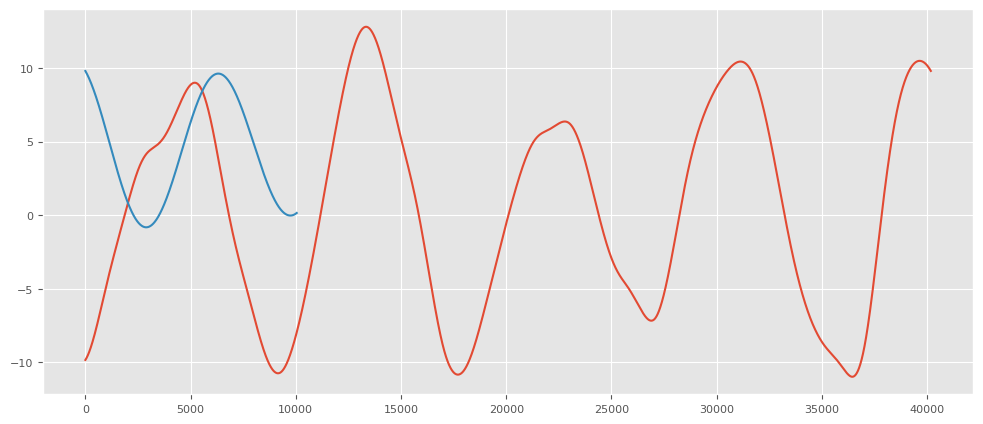

In [17]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_9'])
plt.plot(imf9_eemd_ARIMA_fc)
plt.show()

In [18]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_ARIMA_fc, imf10_eemd_ARIMA_fc], axis = 0)

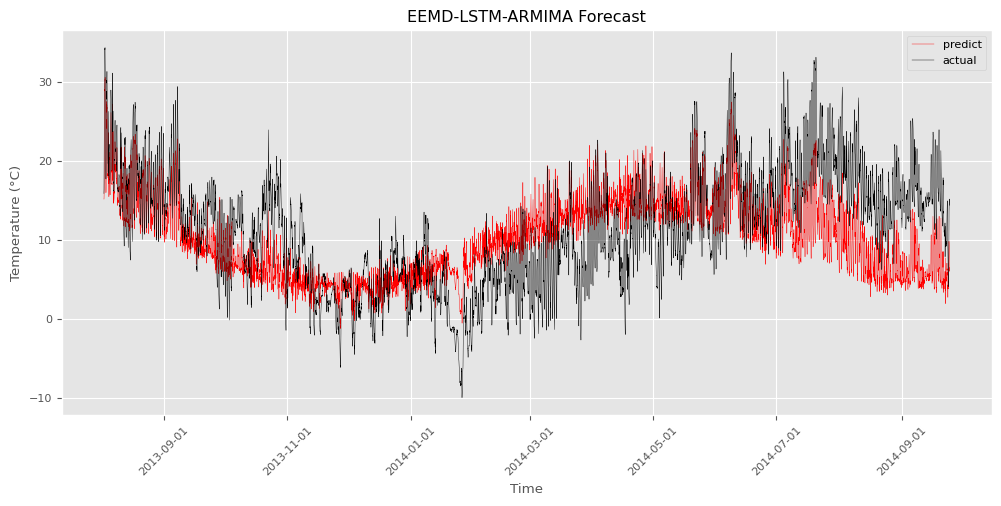

In [19]:
import matplotlib.dates as mdates
import pandas as pd

target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

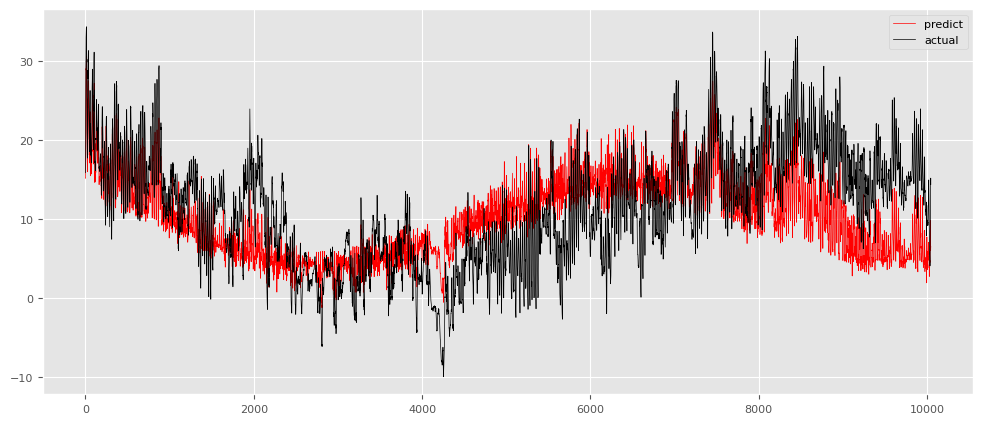

In [20]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [21]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 32.79737769347209 
MAE = 4.75447065210624 
MAPE = 7051063658776.043


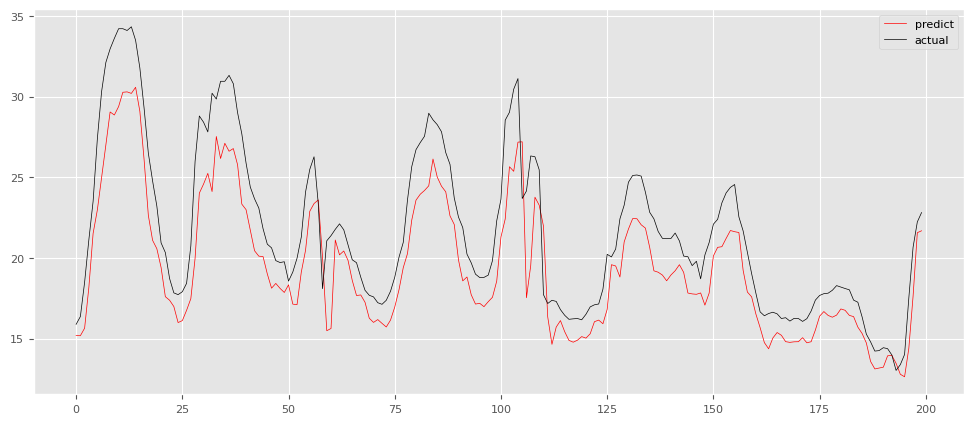

MSE = 32.79737769347209 
MAE = 4.75447065210624 
MAPE = 7051063658776.043


In [22]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [23]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
# imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))

In [30]:
imf9_eemd_ARIMA_fc_train = imf9_eemd_ARIMA_fit.predict(start=0, end=len(imf9_train)-1)
imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.predict(start=0, end=len(imf10_train)-1)

In [24]:
# imf9_eemd_ARIMA_fc = imf9_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))
# imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))

In [31]:
imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_ARIMA_fc_train, imf10_eemd_ARIMA_fc_train], axis = 0)

In [32]:
from scipy.optimize import minimize

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 13.391083
         Iterations: 42
         Function evaluations: 84
[4.24187392]


In [33]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 41.83059051946638 
MAE = 5.272604365294267 
MAPE = 10854687708606.84


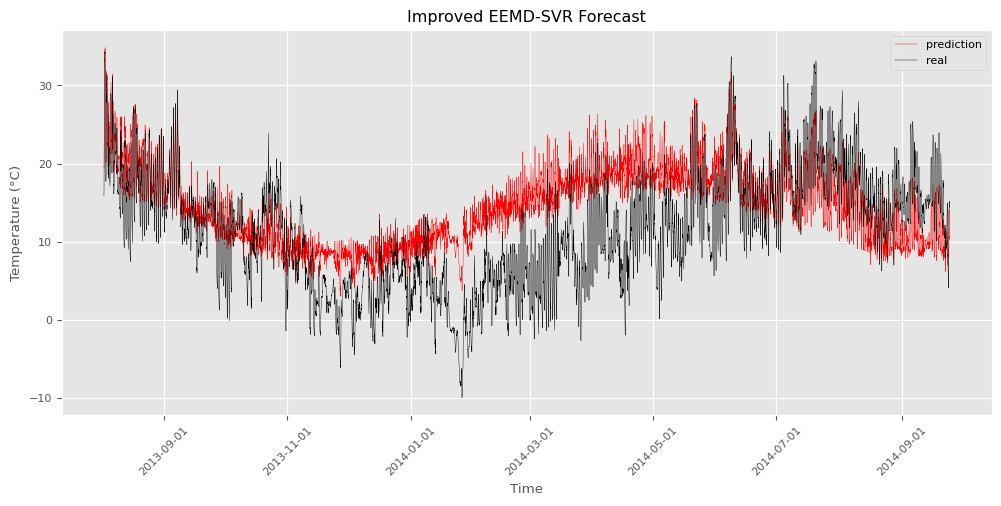

In [34]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

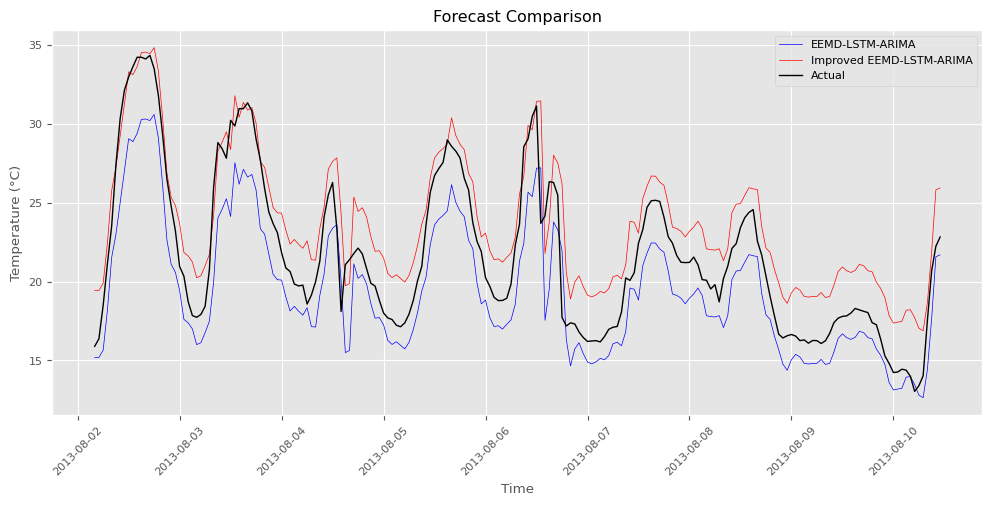

In [35]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()